# But, what is NLP?

NLP is a branch of AI, that deals with the interaction between computers and humans using the natural language. Most NLP techniques rely on Machine Learning to make sense of natural language. 
The ultimate objective of NLP is to read, decipher, understand and make sense of human languages

Typical NLP use cases - 
* Voice assistants, Ok Google, Siri, Cortana
* Language Translation, Google translate, Bing
* Gmail's spam detection filter
* MS Word's grammatical mistake feature

There are 2 broad approaches of handling NLP problems - Syntactic and Semantic Analysis

1. Syntax - Syntax in a code means the rules that need to followed for that particular programming language. Syntax in a language means the grammatical rules that need to be followed.
      Like POS tagging, lemmatization, stemming etc

2. Semantic - Semantic analytics dive deeper into the language to understand meaning that is conveyed by the text and sentence structure.
      Like NERs, NLU etc


Above is a short summary of this [Article](https://becominghuman.ai/a-simple-introduction-to-natural-language-processing-ea66a1747b32)

From machine learning perspective, NLP is about being as creative as we can get with converting our text to numbers. Why is that? Because ML models don't take text as input. In this notebook, we will use the following approach to break an NLP problem and derive insights from it - 
1. Get the text
2. Convert it into numbers
3. Modelling
4. Predictions


We will start with a baseline TF-IDF model and build on it using DNN, LSTM, GRU, Conv and Transfer learning.

In [1]:
# Import libraries
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras import layers
import datetime
import numpy as np

# Let's define Universal Random State
random_state = 42

# For TensorBoard, let's define log storage directory
SAVE_DIR = 'model_logs'

#### The below code block can be used to download data from kaggle directly into Colab

In [2]:
## Data - We will use Kaggle's disaster tweets dataset

# Natural Language Processing with Disaster Tweets

In [3]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 6.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73052 sha256=672f2f461ad59f0e8e2e1a3fa367b2159742f54f02d48178145d7009672dca95
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
from google.colab import files
files.upload()

In [5]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle competitions download -c 'nlp-getting-started'

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 111MB/s]


In [9]:
! mkdir input_data

In [10]:
! unzip nlp-getting-started.zip -d input_data

Archive:  nlp-getting-started.zip
  inflating: input_data/sample_submission.csv  
  inflating: input_data/test.csv     
  inflating: input_data/train.csv    


### Let's deep dive in the data

Kaggle created 3 files for us - train, test and sample-submission
We will read the files, do some EDA and then move forward

In [11]:
train_df = pd.read_csv('input_data/train.csv')
test_df = pd.read_csv('input_data/test.csv')

print("Train Data Size : ", len(train_df))
print("Test Data Size : ", len(test_df))

Train Data Size :  7613
Test Data Size :  3263


In [12]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [13]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [14]:
# Data desc on Kaggle mentions that the location has this distribution - 
                  # USA -> 1%
                  # RoW -> 65%
                  # Null-> 33%

In [15]:
# What about keywords?
train_df[train_df['keyword'].notnull()].head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [16]:
# Are key words always part of the text? If so, then can we just ignore those?
train_df[train_df['keyword'].notnull()].apply(lambda x: x.keyword in x.text, axis=1)

31       True
32      False
33       True
34       True
35      False
        ...  
7578     True
7579     True
7580     True
7581     True
7582     True
Length: 7552, dtype: bool

In [17]:
# Not always true!! Let's see in the later stages if we can somehow use this added information

In [18]:
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

Another Binary Classification Problem. Fairly balanced target (60-40)

  1 - Disaster Related Tweet
  
  2 - Not related to Disaster

In [19]:
# Let's print out few 1s and 0s

positive_tweet_sample = train_df[train_df['target'] == 1]['text'].head().tolist()
negative_tweet_sample = train_df[train_df['target'] == 0]['text'].head().tolist()


print("Disaster Related Tweets : ", '\n')
for i in range(5):
  print('\t', positive_tweet_sample[i])
  print('\t', '-'*20)
print('\n')
print("Non-Disaster Related Tweets : ", '\n')
for i in range(5):
  print('\t', negative_tweet_sample[i])
  print('\t', '-'*20)

Disaster Related Tweets :  

	 Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
	 --------------------
	 Forest fire near La Ronge Sask. Canada
	 --------------------
	 All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
	 --------------------
	 13,000 people receive #wildfires evacuation orders in California 
	 --------------------
	 Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
	 --------------------


Non-Disaster Related Tweets :  

	 What's up man?
	 --------------------
	 I love fruits
	 --------------------
	 Summer is lovely
	 --------------------
	 My car is so fast
	 --------------------
	 What a goooooooaaaaaal!!!!!!
	 --------------------


Train-Test Split (Or Train Validation Split)

Since the testing data doesn't have any labels, we will have to split our training data into train and validation (or test). How about 90-10 for starters

In [20]:
# Define test_size
test_size = 0.1

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df['text'].to_numpy(), train_df['target'].to_numpy(),
                                                                            test_size = test_size,
                                                                            random_state = random_state)

In [21]:
# Size of training and validation sets
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

## Convert text data into numbers

The next step would be to convert string data into numbers. Our labels are alreay numerical, so no need for LabelEncoder, but for tweet text, we surely need to convert.

There are 2 major approaches of converting text into numbers - 

* **Tokenization** - A mapping, or a lookup, for a word/sub-word/character. We can do following types of tokenization - 

      1. Word-Level Tokenization : Assign every word in the sequence it's own token. For example, in the sentence, 'I Love Pizza', we can assign I:0, Love:2, Pizza:3
      2. Character-Level Tokenization : Assign token to every character in the corpus. 
      3. Sub-word-Level Tokenization : This involves breaking words into parts and assigning tokens to each part. 
                    For example, 'I love Pineapple', can be broken
                    into 'I Lo ve pine app le' and then assign 
                    tokens to these sub-words. In case of sub-word
                    tokenization, a word might have multiple tokens

* **Embeddings** - Embedding is a representation of natural language which can be learned. This representation comes in the form of a Feature vector. For example, the word 'Football' can be represented by a 5-d feature vector : [-0.3456, 0.2352, 0.3454, 0.2576, 0.9865]. Importantly, the size of the feature vector is tune-able. We can use embeddings in 2 ways : 

      1. Create your own embedding : Once your text has been converted to
                      numbers (required for Embedding), you can pass this
                      to Keras Embedding Layer and an embedding
                      representation will be learned during model training
      2. Use a pre-learned embedding : `Transfer Learning`. 
                      The power of Deep Learning. You can use pre-created
                      embedding layers and fine-tune them on your
                      own purpose. The benefit here is, for example BERT
                      is trained on entire wikipedia. It is not possible
                      that every time we perform a sentiment analysis we
                      train it for months on such a huge corpus. We rather
                      use the results from the previous training and
                      adapt it to our purpose.


To tokenize our words, we'll use the helpful preprocessing layer `tf.keras.layers.experimental.preprocessing.TextVectorization`.

The TextVectorization layer takes the following parameters:

* max_tokens - The maximum number of words in your vocabulary (e.g. 20000 or the number of unique words in your text), includes a value for OOV (out of vocabulary) tokens.
* standardize - Method for standardizing text. Default is "lower_and_strip_punctuation" which lowers text and removes all punctuation marks.
* split - How to split text, default is "whitespace" which splits on spaces.
* ngrams - How many words to contain per token split, for example, ngrams=2 splits tokens into continuous sequences of 2.
* output_mode - How to output tokens, can be "int" (integer mapping), "binary" (one-hot encoding), "count" or "tf-idf". See documentation for more.
* output_sequence_length - Length of tokenized sequence to output. For example, if output_sequence_length=150, all tokenized sequences will be 150 tokens long.
* pad_to_max_tokens - If True (default), the output feature axis will be padded to max_tokens even if the number of unique tokens in the vocabulary is less than max_tokens.



In [22]:
# What's the number of distinct words in the corpus?
from collections import Counter
# Instantiate Counter
results = Counter()
# Convert text to lower case, split on whitespace, and create dict
train_df['text'].str.lower().str.split().apply(results.update)
# Shape of Dictionary
print(len(results.keys()))

27983


In [23]:
# Close to 30K if we include test data as well. We'll choose 10K as the vocab_size (or max_tokens)

In [24]:
# Average tweet length?
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [25]:
# We will choose output_sequence_length as 15, since Average Tweet Length is 15

In [26]:
# Initialize Text Vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vocab_size = 10000
output_len = 15

text_vectorizer = TextVectorization(max_tokens=vocab_size,
                                    output_sequence_length = output_len,
                                    output_mode = 'int')

# Adapt the vectorizer created above to our training data (Adapt is like fit-transform)
text_vectorizer.adapt(train_sentences)

In [27]:
# Let's see how this vectorizer is working on few sample text

sample_corpus = [['I love Pizza'],
                 ['I love Football'],
                 ['The dog loves cricket']]
text_vectorizer(sample_corpus)

<tf.Tensor: shape=(3, 15), dtype=int64, numpy=
array([[   8,  107, 3526,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   8,  107, 1528,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   2, 1014, 2401, 3964,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [28]:
# So, every output is of length 15. Same word gets same token
# Also, notice that love and loves get different tokens. Ideally we should convert the word into it's stem and assign tokens to the stem

In [29]:
# Explore the vectorizer a bit more

# All words in the vocab
words_in_vocab = text_vectorizer.get_vocabulary()
# First 5 words in the vocab
first5_words = words_in_vocab[:5]
# Last 5 words in the vocab
last5_words = words_in_vocab[-5:]

print("Total numbers of words in the vocab : ", len(words_in_vocab))
print("Top 5 most popular words in the vocab : ", first5_words)
print("Top 5 least popular words in the vocab : ", last5_words)

Total numbers of words in the vocab :  10000
Top 5 most popular words in the vocab :  ['', '[UNK]', 'the', 'a', 'in']
Top 5 least popular words in the vocab :  ['pakthey', 'pakistan\x89Ûªs', 'pakistans', 'pajamas', 'paints']


### Create an embedding using Keras Embedding Layer

Next, we convert the tokens to an embedding. One major advantage is that an embedding layer can be train-able, so we can update the tokens if we've obtained from text vectorizer

Main parameters we are looking for - 
1. input_dim = Size of the vocabulary, i.e. maximum integer index + 1.
2. input_length = Length of input sequences being passed to the embedding (15 here)
3. output_dim = Output array size (Map input to this dim. If 100, we get output of size (m, input_len, 100) where m is the number of training examples)

Please have a look at the official doc for better understanding - [EmbeddingLayer](https://keras.io/api/layers/core_layers/embedding/)

In [30]:
from tensorflow.keras import layers

embedding_output = 128

embedding = layers.Embedding(input_dim = vocab_size,
                             output_dim = embedding_output,
                             input_length = output_len)

In [31]:
# Let's see what exactly this 'thing' is doing
random_sentence = random.choice(train_sentences)
print("Original Text : ", random_sentence)

# Let's embed this random sentence
print("\n\nEmbedded version")
embed_random_sentence = embedding(text_vectorizer([random_sentence]))
embed_random_sentence

Original Text :  Zouma has just absolutely flattened that guy ??


Embedded version


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.00274988,  0.02107574,  0.04382792, ..., -0.00950354,
         -0.03907083,  0.02399908],
        [-0.01528521,  0.02033484,  0.0409759 , ...,  0.01596195,
         -0.01545292,  0.04755545],
        [-0.04997013, -0.0128377 ,  0.00185167, ..., -0.02501137,
         -0.04683727,  0.01078478],
        ...,
        [ 0.01991537, -0.04686571, -0.0173362 , ...,  0.03945679,
         -0.02940768, -0.0462914 ],
        [ 0.01991537, -0.04686571, -0.0173362 , ...,  0.03945679,
         -0.02940768, -0.0462914 ],
        [ 0.01991537, -0.04686571, -0.0173362 , ...,  0.03945679,
         -0.02940768, -0.0462914 ]]], dtype=float32)>

In [32]:
# Take closer look at tensor shape - <tf.Tensor: shape=(1, 15, 128), dtype=float32
# 1 input example. 15 words in every tweet. Or 15 max/min tokens per tweet. 128 dimensional embedding. So, every token gets converted to 128 dims


# Check out a single token's embedding
embed_random_sentence[0][0], len(embed_random_sentence[0][0])

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.00274988,  0.02107574,  0.04382792,  0.04646391, -0.03321173,
        -0.02048935, -0.01263696,  0.01007573,  0.01729831, -0.00256107,
        -0.00378267, -0.00450552, -0.04219989,  0.0218769 , -0.01188074,
         0.00928771,  0.04947703,  0.01785209,  0.013002  , -0.00349969,
        -0.00717063,  0.0412236 , -0.03982846,  0.04234454,  0.04068017,
         0.02210693, -0.04309304,  0.04687073,  0.04674614, -0.0183751 ,
        -0.0361227 ,  0.02336823,  0.02560247, -0.0445343 , -0.03590717,
         0.03536388, -0.00129291,  0.04760811, -0.00058375, -0.04822625,
         0.03230366,  0.0351712 ,  0.0105313 , -0.03527353,  0.03819317,
        -0.00794309, -0.03070226, -0.01783469,  0.00570527,  0.01713128,
        -0.01179362,  0.006131  ,  0.02196932, -0.01588956, -0.04539796,
        -0.04628457,  0.00811573, -0.00176873, -0.04640929, -0.02768323,
        -0.04560175, -0.04924288,  0.04518558, -0.02419056,  0.00512816,
  

In [33]:
# So, every token (or a word if we use word-level tokenization) gets mapped into a 128 dimensional space

# What a beautiful matrix. LOL!!

## Modelling

We'll be building the following:

* Model 0: Naive Bayes (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model
* Model 3: GRU model
* Model 4: Bidirectional-LSTM model
* Model 5: 1D Convolutional Neural Network
* Model 6: TensorFlow Hub Pretrained Feature Extractor
* Model 7: Same as model 6 with 10% of training data

In [34]:
# Since we will doing a lot of experimentation, it's a good idea we create some base functions
# Following function evaluates: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.
  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"
  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

def compare_baseline_to_new_results(baseline_results, new_model_results):
  """
  Function to compare results between baseline model and any other model
  Both baseline and new model's results are dictionaries of Accuracy, F1, Precision, Recall
  """
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

### Model 0 - Baseline NB Model

Just like TF, Scikit Learn models also don't take strings as inputs (DUHH!!)

So, we will use [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) score for each word to convert text to number

Also, we will create Sklearn pipeline to get the results

But before that, a bit about TF-IDF. TF-IDF evaluated how relevant a word is in a collection of documents. It has 2 terms - 

1. Term Frequency (TF) - This measures the frequency of a word in a doc. We normalise the effect of the words by the total number of words in the doc.

> TF = Freq of word W in Doc D / Total number of words in D

2. Inverse Document Frequency (IDF) - This measures the importance of a document in the corpus. We are only interested in the number of docs the word W is present and NOT IN THE FREQUENCY.

> IDF Definition = Inverse of (Number of docs in which word W occurs / Total number of Docs in Corpus). However, if number of docs in which W occurs is zero, then we might get DivisionByZeroError
    
So, IDF is defined as - 

> IDF = log(N / (df + 1)), where df is the number of docs in which W occurs

So, putting it all together, TF-IDF score for a word W is -
  
    TFIDF = tf(w, d) * log(N / (df + 1)
            where w : word for which TFIDF is being calculated
                  d : current document
                 df : number of docs in which w occurs
                  N : Total number of docs


Notice that TF-IDF normalizes the score for words like in, the, as, so (Stopwords). TF score will be high, but since these words will be present in most of the docs, IDF score will be very low. Still, it's a good practice to perform Data Cleaning


In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and MNB pipeline
model_0 = Pipeline([
                    ('tfidf', TfidfVectorizer()),
                    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

# Make predictions
baseline_preds = model_0.predict(val_sentences)
print("Few predictions : ", baseline_preds[:10])

# Evaluate the model on Testing data
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

# Evaluation metrics
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

Few predictions :  [0 0 0 0 0 0 0 0 0 1]
Our baseline model achieves an accuracy of: 77.82%


{'accuracy': 77.82152230971128,
 'f1': 0.7703527809038113,
 'precision': 0.792992256322435,
 'recall': 0.7782152230971129}

### Model 1 - A simple Dense Model

Too simple I'd say. Basically we are taking text and labels as input, do the tokenization, create embedding, convert embedding into lower dimension (like avg) and then pass it to 1 fully connected layer

In [36]:
# We have 1-d input. Tweet as a string. 
inputs = layers.Input(shape=(1,), dtype = 'string')
# Tokenize the text
x = text_vectorizer(inputs)
# Create embeddings using embedding layer created above
x = embedding(x)
# Convert to lower dimesnion, using Average
x = layers.GlobalAveragePooling1D()(x)

# Create outputs - since the output is Binary, we'll use Sigmoid
outputs = layers.Dense(1, activation = 'sigmoid')(x)

# Create the model
model_1 = tf.keras.Model(inputs, outputs, name = 'model_1_dense')

# Compile the model
model_1.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# Get a short summary of the model
model_1.summary()

# Fit the model
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(dir_name = SAVE_DIR,
                                                                       experiment_name = 'Simple_Dense_Model')])

# Evaluate the model
model_1.evaluate(val_sentences, val_labels)

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________
Saving TensorBoard log files to: model_logs/Simple_Dense_Model/20210724-070412
Epoch 1/5
215/215 [===========

[0.4994889199733734, 0.7847769260406494]

In [37]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.4995 - accuracy: 0.7848


[0.4994889199733734, 0.7847769260406494]

In [38]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10] # only print out the first 10 prediction probabilities

array([[0.03370094],
       [0.15840867],
       [0.39773268],
       [0.02160904],
       [0.58505815],
       [0.16424638],
       [0.02105337],
       [0.27672717],
       [0.11914557],
       [0.9040068 ]], dtype=float32)

Sigmoid function returns probabilities and these probabilities need to be converted to 1,0.

We will use a simple round function to convert probabilities to binary. This means we use 0.5 as a cut-off. However, for experimentation, we can ROC curve to determine threshold

In [39]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 1., 0., 0., 0., 0., 1.], dtype=float32)>

In [40]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.4776902887139,
 'f1': 0.7826583757567217,
 'precision': 0.7854715275975119,
 'recall': 0.7847769028871391}

In [41]:
# Is our simple Keras model better than our baseline model?

np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([ True, False,  True,  True])

In [42]:
# Compare Model's results to Baseline model

compare_baseline_to_new_results(baseline_results=baseline_results, 
                                new_model_results=model_1_results)

Baseline accuracy: 77.82, New accuracy: 78.48, Difference: 0.66
Baseline precision: 0.79, New precision: 0.79, Difference: -0.01
Baseline recall: 0.78, New recall: 0.78, Difference: 0.01
Baseline f1: 0.77, New f1: 0.78, Difference: 0.01


### RNN

Next, we look at another type of ANN architecture - Recurrent Neural Networks. These are based on simple premise of using the information from previous state and define next steps using inputs from the previous state. This is specially useful in problems like Text, Audio etc (basically Sequences). 

Recurrent neural networks can be used for a number of sequence-based problems:

1. **One to one**: one input, one output, such as image classification.
2. **One to many**: one input, many outputs, such as image captioning (image input, a sequence of text as caption output).
3. **Many to one**: many inputs, one outputs, such as text classification (classifying a Tweet as real diaster or not real diaster).
4. **Many to many**: many inputs, many outputs, such as machine translation (translating English to Spanish) or speech to text (audio wave as input, text as output).

RNNs can be broadly seen under following variants - 

1. Long Short Term Memory (LSTM) Units
2. Gated Recurrent Units (GRU)
3. Bi-Directional RNNs



### Model 2 - LSTM

LSTM is a type of RNN based on the paradigm of using information from previous state. Long Short Term Memory networks allow the information to persist, unlike traditional neural nets, and can be thought of as multiple copies of the same network. Same can be applied to RNNs. However, as the length of the state grows, i.e., the distance in the past we have to go, RNN become slow. This problem is overcome by LSTMs. LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!


The model structure remains pretty same as Model 1, just that we will add an LSTM layer between embedding and output - 

`Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)`


In [43]:
from tensorflow.keras import layers

# Define the input layer
inputs = layers.Input(shape=(1,) , dtype = "string")

# Vectorize the inputs
x = text_vectorizer(inputs)

# Convert to embeddings
x = embedding(x)

# Add LSTM layer
x = layers.LSTM(64)(x)

# Define output
outputs = layers.Dense(1, activation='sigmoid')(x)

# Create the model
model_2 = tf.keras.Model(inputs, outputs, name = 'Model_2_LSTM')

In [44]:
# Compile the model
model_2.compile(loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [45]:
# Model Summary
model_2.summary()

Model: "Model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [46]:
# Fit the model

model_2.fit(train_sentences,
            train_labels,
            epochs = 5,
            validation_data = (val_sentences, val_labels),
            callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                    "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20210724-070434
Epoch 1/5
215/215 [==============================] - 8s 28ms/step - loss: 0.2275 - accuracy: 0.9123 - val_loss: 0.5467 - val_accuracy: 0.7585
Epoch 2/5
215/215 [==============================] - 5s 25ms/step - loss: 0.1566 - accuracy: 0.9410 - val_loss: 0.7313 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 5s 25ms/step - loss: 0.1282 - accuracy: 0.9514 - val_loss: 0.6359 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 5s 25ms/step - loss: 0.1067 - accuracy: 0.9591 - val_loss: 0.7386 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0867 - accuracy: 0.9653 - val_loss: 0.8209 - val_accuracy: 0.7651


In [47]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

((762, 1), array([[0.00330544],
        [0.04036021],
        [0.00636348],
        [0.00115278],
        [0.53156686],
        [0.03145063],
        [0.0011037 ],
        [0.04730874],
        [0.02203816],
        [0.99867433]], dtype=float32))

In [48]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 1., 0., 0., 0., 0., 1.], dtype=float32)>

In [49]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 76.50918635170603,
 'f1': 0.7615709832938355,
 'precision': 0.7670119425815111,
 'recall': 0.7650918635170604}

In [50]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 77.82, New accuracy: 76.51, Difference: -1.31
Baseline precision: 0.79, New precision: 0.77, Difference: -0.03
Baseline recall: 0.78, New recall: 0.77, Difference: -0.01
Baseline f1: 0.77, New f1: 0.76, Difference: -0.01


### Model 3 - GRU

Gated Recurrent Units are similar to LSTM, just have lesser parameters. We will use the same process as LSTMs, where instead of LSTM layer, we will use GRU layer - 

`Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)`

In [51]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers

# Define the input layer
inputs = layers.Input(shape=(1,) , dtype = "string")

# Vectorize the inputs
x = text_vectorizer(inputs)

# Convert to embeddings
x = embedding(x)

# Add LSTM layer
x = layers.GRU(64)(x)

# Define output
outputs = layers.Dense(1, activation='sigmoid')(x)

# Create the model
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [52]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [53]:
# Get a summary of the GRU model
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________


In [54]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20210724-070518
Epoch 1/5
215/215 [==============================] - 8s 28ms/step - loss: 0.1536 - accuracy: 0.9402 - val_loss: 0.8326 - val_accuracy: 0.7349
Epoch 2/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0837 - accuracy: 0.9710 - val_loss: 0.9260 - val_accuracy: 0.7559
Epoch 3/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0716 - accuracy: 0.9739 - val_loss: 0.8237 - val_accuracy: 0.7467
Epoch 4/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0632 - accuracy: 0.9761 - val_loss: 1.1618 - val_accuracy: 0.7493
Epoch 5/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0594 - accuracy: 0.9746 - val_loss: 0.9870 - val_accuracy: 0.7585


In [55]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

((762, 1), array([[5.2599609e-03],
        [2.1683514e-02],
        [4.1362643e-03],
        [3.1420588e-04],
        [9.3161309e-01],
        [5.6369007e-02],
        [2.6491284e-04],
        [2.3854643e-02],
        [1.9202173e-02],
        [9.9948800e-01]], dtype=float32))

In [56]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 1., 0., 0., 0., 0., 1.], dtype=float32)>

In [57]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 75.8530183727034,
 'f1': 0.7561532996294926,
 'precision': 0.7585277801813235,
 'recall': 0.7585301837270341}

In [58]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 77.82, New accuracy: 75.85, Difference: -1.97
Baseline precision: 0.79, New precision: 0.76, Difference: -0.03
Baseline recall: 0.78, New recall: 0.76, Difference: -0.02
Baseline f1: 0.77, New f1: 0.76, Difference: -0.01


### Model 4 - Bi-Directional RNNs

We have already trained 2 variants of RNNs - LSTM and GRU. Next, we look at another type of RNN - Bi-Directional RNN. 

A standard RNN will process the data from left to right. Bi-Directional RNN will process the sequence from left-right and then also from right-left. Intuitively, someone reads a sentence from left to right and if it doesn't make much sense, go over the sentence again from right to left. 

More often than often, Bi-Directional RNNs provide improved performance compared to vanilla RNNs. However, this comes at the cost of longer training times and increased model parameters, since left-right and right-left.

Here again, we will follow the same structure as in model 3 and 4 - 

`Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)`

In [59]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers

# Define the input layer
inputs = layers.Input(shape=(1,) , dtype = "string")

# Vectorize the inputs
x = text_vectorizer(inputs)

# Convert to embeddings
x = embedding(x)

# Add Bi-Directional layer - Notice how we wrapped LSTM layer inside TF Bidirectional. This can be done with any RNN layer
x = layers.Bidirectional(layers.LSTM(64))(x)

# Define output
outputs = layers.Dense(1, activation='sigmoid')(x)

# Create the model
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [60]:
# Compile the model

model_4.compile(loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [61]:
# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


A lot more parameters!!

In [62]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20210724-070548
Epoch 1/5
215/215 [==============================] - 11s 38ms/step - loss: 0.1062 - accuracy: 0.9677 - val_loss: 0.9372 - val_accuracy: 0.7480
Epoch 2/5
215/215 [==============================] - 7s 33ms/step - loss: 0.0554 - accuracy: 0.9777 - val_loss: 1.1426 - val_accuracy: 0.7467
Epoch 3/5
215/215 [==============================] - 7s 34ms/step - loss: 0.0469 - accuracy: 0.9781 - val_loss: 1.3664 - val_accuracy: 0.7467
Epoch 4/5
215/215 [==============================] - 7s 34ms/step - loss: 0.0452 - accuracy: 0.9781 - val_loss: 1.3134 - val_accuracy: 0.7533
Epoch 5/5
215/215 [==============================] - 7s 34ms/step - loss: 0.0408 - accuracy: 0.9801 - val_loss: 1.5743 - val_accuracy: 0.7402


In [63]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[1.9919872e-04],
       [1.3370216e-03],
       [1.5705824e-04],
       [4.7935242e-05],
       [9.9259597e-01],
       [1.1962119e-01],
       [1.8731938e-05],
       [6.4137757e-02],
       [2.3186803e-03],
       [9.9997473e-01]], dtype=float32)

In [64]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 1., 0., 0., 0., 0., 1.], dtype=float32)>

In [65]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 74.01574803149606,
 'f1': 0.7397021307105048,
 'precision': 0.7395037867691541,
 'recall': 0.7401574803149606}

In [66]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 77.82, New accuracy: 74.02, Difference: -3.81
Baseline precision: 0.79, New precision: 0.74, Difference: -0.05
Baseline recall: 0.78, New recall: 0.74, Difference: -0.04
Baseline f1: 0.77, New f1: 0.74, Difference: -0.03


### Model 5 - CNN

CNN for text? Are you really sure? Well yes, CNNs do actually work pretty good on a lot of text related tasks and sequences.

Main difference between using CNNs for Images and Text is the shape of the data. Images mostly are 2D, or 3D whereas text generally is 1D. So to use CNNs for sequences, we use 1D Convolution operation instead of 2D convolution.

Just like other models, we will follow the similar structure - 

`Inputs (text) -> Tokenization -> Embedding -> Layers -> Outputs (class probabilities)`

  where we will use Conv layer in place of RNN, GRU or LSTM layers used earlier

In [67]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers

# Define the input layer
inputs = layers.Input(shape=(1,) , dtype = "string")

# Vectorize the inputs
x = text_vectorizer(inputs)

# Convert to embeddings
x = embedding(x)

# Add Convolutional layer
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
# Add Max pooling layer
x = layers.GlobalMaxPool1D()(x)

# Define output
outputs = layers.Dense(1, activation='sigmoid')(x)

# Create the model
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

In [68]:
# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [69]:
# Get a summary of our 1D convolution model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 11, 32)            20512     
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,300,545
Trainable params: 1,300,545
Non-trainable params: 0
__________________________________________

In [70]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20210724-070633
Epoch 1/5
215/215 [==============================] - 5s 18ms/step - loss: 0.1223 - accuracy: 0.9638 - val_loss: 1.0370 - val_accuracy: 0.7362
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0707 - accuracy: 0.9726 - val_loss: 1.2108 - val_accuracy: 0.7270
Epoch 3/5
215/215 [==============================] - 4s 16ms/step - loss: 0.0597 - accuracy: 0.9753 - val_loss: 1.3204 - val_accuracy: 0.7375
Epoch 4/5
215/215 [==============================] - 4s 16ms/step - loss: 0.0519 - accuracy: 0.9787 - val_loss: 1.3503 - val_accuracy: 0.7336
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0496 - accuracy: 0.9784 - val_loss: 1.4117 - val_accuracy: 0.7362


In [71]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[1.3613105e-03],
       [1.1492330e-01],
       [2.5122401e-06],
       [2.2962689e-04],
       [1.0084823e-01],
       [6.2544000e-01],
       [4.4272176e-07],
       [5.8962703e-03],
       [2.1587908e-03],
       [9.9998790e-01]], dtype=float32)

In [72]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 1., 0., 0., 0., 1.], dtype=float32)>

In [73]:
# Calculate model_5 evaluation metrics 
model_5_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 73.62204724409449,
 'f1': 0.7360012787549572,
 'precision': 0.7358458439027336,
 'recall': 0.7362204724409449}

In [74]:
# Compare model_5 results to baseline 
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 77.82, New accuracy: 73.62, Difference: -4.20
Baseline precision: 0.79, New precision: 0.74, Difference: -0.06
Baseline recall: 0.78, New recall: 0.74, Difference: -0.04
Baseline f1: 0.77, New f1: 0.74, Difference: -0.03


#### Surprisingly, all the models trained till now are not able to surpass Sklearn base model. Although with proper hyperparameter tuning, this might be changed, but something to keep in mind.

### Transfer Learning

For all the models trained till now, we have created the embeddings from scratch each time. Also, we created the embeddings using whatever limited data we had.

Now, comes in the picture **Transfer Learning**. The paradigm behind Transfer Learning is we use a pre-trained model and adapt it to our task. Generally, these models are trained on huge datasets so they capture a lot of real-world information, and we avoid complex, expensive, and time consuming training everytime. We simply use the information already available with the model, fine-tune on our task and get the results. These models can be readily used out of the box or we can also do training on our custom dataset. The flexibilty this architecture provides is unmatched.

It is a common practice to use pre-learned embeddings through transfer learning and adapt to our use-case. This is one of the biggest advantages of Deep Learning. We will replace the embedding layer created in previous models, and replace it with a pre-trained embedding

There are a lot of pre-trained models available online. Best would be to test out and chose whatever works best for the problem at hand. We will use **Universal Sentence Encoder** from [TensorFlow Hub](https://tfhub.dev/google/universal-sentence-encoder/4) . Of course, instead of token-level encoding, it performs sentence level encoding. 

We created a 128 dimension embedding for each token in all earlier models. Now, we will create 512 dimension embedding for each sentence

> An encoder is the name for a model which converts raw data such as text into a numerical representation (feature vector), a decoder converts the numerical representation to a desired output.


Before we use this architecture on our data, let's create a model on sample data to understand what this thing is actually doing!

In [79]:
# Import TF Hub - hub for all pre-trained TF models
import tensorflow_hub as tfhub

# Load the model of interest
embed = tfhub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder

In [80]:
# Let's see the encodings on few test sentences
embed_samples = embed(["When you call the universal sentence encoder on a sentence, it turns it into numbers.",
                       "Are Messi and Ronaldo equal in this parallel universe?"])

In [82]:
# It returns the embeddings for all the sentences present in the corpus
len(embed_samples)

2

In [83]:
# What is the output shape of every sentence?
for sample in embed_samples:
  print(len(sample))

512
512


In [85]:
# Let's see the output for second sentence - First 50 out of all 512
embed_samples[1][:50]

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([-0.03319652, -0.06250314, -0.05775177,  0.04554421,  0.0664003 ,
        0.04929043, -0.00702602,  0.04694632, -0.07327016,  0.05128047,
       -0.0767508 , -0.02136312,  0.0101046 ,  0.02967457,  0.02525571,
       -0.06242148, -0.02897203,  0.04542281,  0.01799867, -0.03566683,
        0.01611911,  0.01546892,  0.0413161 ,  0.07280979,  0.06046129,
        0.01227951,  0.00667628,  0.0305739 ,  0.05944862, -0.06454698,
        0.03109399, -0.03526135, -0.04836899,  0.06477877, -0.00129074,
       -0.03034437, -0.02017293,  0.01775777,  0.06892993,  0.04102188,
       -0.07397444, -0.02912454,  0.02973827, -0.00180943, -0.01394865,
        0.04235648, -0.00471703,  0.06528436,  0.06631621, -0.022871  ],
      dtype=float32)>

#### Great! Now let's try this embedding layer on our data.

We will create a layer of embedding directly using the Universal Sentence Encoder (USE) and replace the embedding layer we used in previous models. We can directly provide the URL to tf.keras. Yeah, that's cool, right!!

In [88]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = tfhub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [89]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
                               sentence_encoder_layer, # take in sentences and then encode them into an embedding
                                layers.Dense(64, activation="relu"),
                                layers.Dense(1, activation="sigmoid")],
                               name="model_6_USE")

In [90]:
# Compile the model

model_6.compile(loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [91]:
# Get the summary
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_5 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


#### Notice!! A lot less trainable params...... non-trainable parameters coming from the embedding layer

These are pre-trained weights the USE has learned when it was trained on WikiPedia, web news and other data sources. The trainable parameters are only coming from dense layers. We have kept pre-trained parameters frozen and using it a feature-extractor. We can also fine-tune these weights if we paas trainable=True in keras layers instance

In [94]:
# Train a classifier on pre-trained embeddings

model_6.fit(train_sentences,
            train_labels,
            epochs = 5,
            validation_data = (val_sentences, val_labels),
            callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                          "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20210724-073118
Epoch 1/5
215/215 [==============================] - 10s 34ms/step - loss: 0.5038 - accuracy: 0.7872 - val_loss: 0.4238 - val_accuracy: 0.8058
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4172 - accuracy: 0.8143 - val_loss: 0.4073 - val_accuracy: 0.8215
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4035 - accuracy: 0.8228 - val_loss: 0.4024 - val_accuracy: 0.8202
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3948 - accuracy: 0.8282 - val_loss: 0.4013 - val_accuracy: 0.8320
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3886 - accuracy: 0.8279 - val_loss: 0.3970 - val_accuracy: 0.8255


In [95]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.09412295],
       [0.08030161],
       [0.3610992 ],
       [0.17669725],
       [0.22204804],
       [0.10356861],
       [0.11993402],
       [0.07558867],
       [0.36455292],
       [0.7373039 ]], dtype=float32)

In [97]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)>

In [98]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 82.54593175853019,
 'f1': 0.824006448012896,
 'precision': 0.826578552829881,
 'recall': 0.8254593175853019}

In [99]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 77.82, New accuracy: 82.55, Difference: 4.72
Baseline precision: 0.79, New precision: 0.83, Difference: 0.03
Baseline recall: 0.78, New recall: 0.83, Difference: 0.05
Baseline f1: 0.77, New f1: 0.82, Difference: 0.05


In [100]:
# Better performance out of the box than every other model!! Transfer Learning, man!!

### Model 7 - USE on 10% Data

One of the benefits of using transfer learning methods, such as, the pretrained embeddings within the USE is the ability to get great results on a small amount of data (the USE paper even mentions this in the abstract).

Let's test this!

In [102]:
# To subset only 10% data, we can always use Train Test Split - 

train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=random_state)

In [104]:
print("Total Training Examples : ", len(train_sentences))
print("Total Training Examples in the 10% subset : ", len(train_sentences_10_percent))

Total Training Examples :  6851
Total Training Examples in the 10% subset :  686


In [108]:
# We need to also ensure that class distribution remains more or less similar

print('Class distribution in original data : \n', pd.Series(train_labels).value_counts())
print('\nClass distribution in subset data : \n', pd.Series(train_labels_10_percent).value_counts())

Class distribution in original data : 
 0    3916
1    2935
dtype: int64

Class distribution in subset data : 
 0    391
1    295
dtype: int64


In [109]:
# This works!

In [110]:
# Let's clone model_6 using keras.clone_model() . This will clone the model architecture, but reset the learned weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_5 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [111]:
# Yeah, everything same!

In [112]:
# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20210724-074455
Epoch 1/5
22/22 [==============================] - 5s 108ms/step - loss: 0.6750 - accuracy: 0.6676 - val_loss: 0.6505 - val_accuracy: 0.7651
Epoch 2/5
22/22 [==============================] - 0s 20ms/step - loss: 0.6129 - accuracy: 0.7988 - val_loss: 0.5926 - val_accuracy: 0.7848
Epoch 3/5
22/22 [==============================] - 0s 22ms/step - loss: 0.5428 - accuracy: 0.8105 - val_loss: 0.5361 - val_accuracy: 0.7690
Epoch 4/5
22/22 [==============================] - 0s 19ms/step - loss: 0.4836 - accuracy: 0.8222 - val_loss: 0.4973 - val_accuracy: 0.7756
Epoch 5/5
22/22 [==============================] - 0s 20ms/step - loss: 0.4429 - accuracy: 0.8236 - val_loss: 0.4745 - val_accuracy: 0.7848


In [113]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.3351642 ],
       [0.19764724],
       [0.59034574],
       [0.14418533],
       [0.55956185],
       [0.17059395],
       [0.27652115],
       [0.26920205],
       [0.16069672],
       [0.66778183]], dtype=float32)

In [114]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 1., 0., 0., 0., 0., 1.], dtype=float32)>

In [115]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 78.4776902887139,
 'f1': 0.7842269740851211,
 'precision': 0.7842138433288723,
 'recall': 0.7847769028871391}

In [116]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 77.82, New accuracy: 78.48, Difference: 0.66
Baseline precision: 0.79, New precision: 0.78, Difference: -0.01
Baseline recall: 0.78, New recall: 0.78, Difference: 0.01
Baseline f1: 0.77, New f1: 0.78, Difference: 0.01


In [117]:
# Again, better performance straight outta box than a lot of other architectures. 

## Model Performance Comparison

Let's compare the performance of all the models, and since this was a binary classification problem, Accuracy, Precision, Recall and F1 Score are good enough for comparison

Note that all the models were trained on the same data, except for model_7 which was trained on only 10% of the entire data

In [119]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"Baseline": baseline_results,
                                  "Simple Dense": model_1_results,
                                  "LSTM": model_2_results,
                                  "GRU": model_3_results,
                                  "Bi-Directional RNN": model_4_results,
                                  "Conv1D": model_5_results,
                                  "USE": model_6_results,
                                  "USE_10percentData": model_7_results})

all_model_results = all_model_results.transpose()
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
Baseline,0.778215,0.792992,0.778215,0.770353
Simple Dense,0.784777,0.785472,0.784777,0.782658
LSTM,0.765092,0.767012,0.765092,0.761571
GRU,0.758530,0.758528,0.758530,0.756153
Bi-Directional RNN,0.740157,0.739504,0.740157,0.739702
Conv1D,0.736220,0.735846,0.736220,0.736001
USE,0.825459,0.826579,0.825459,0.824006
USE_10percentData,0.784777,0.784214,0.784777,0.784227


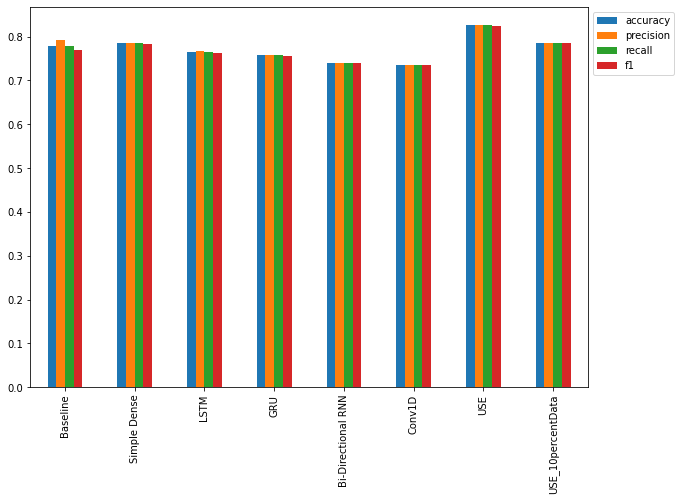

In [120]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

So the pre-trained USE trained on just 10% of the data outperformed a lot of other models! 

That's the power of Transfer Learning!